# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [1]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv

In [11]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension("plotly")

In [3]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [4]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [5]:
# Getting the data from the top 10 expensive neighbourhoods
house_value_by_neighbourhoods = (
    to_data
    .groupby("neighbourhood")
    .mean()
    .sort_values(["average_house_value"], ascending=False)
)
top_expensive_neighbourhoods_df = house_value_by_neighbourhoods.iloc[0:10]

# Calculate the total number of dwelling types units per year
dwellings_per_unit_per_year = to_data.drop(['neighbourhood', 'average_house_value', 'shelter_costs_owned', 'shelter_costs_rented'], axis=1)
dwellings_per_unit_per_year = dwellings_per_unit_per_year.groupby("year").sum()

# Calculate the average monthly shelter costs for owned and rented dwellings
month_shelter_cost_per_year = to_data.drop(['neighbourhood','single_detached_house','apartment_five_storeys_plus','movable_dwelling', 'semi_detached_house', 'row_house', 'duplex', 'apartment_five_storeys_less','other_house', 'average_house_value'], axis=1)
month_shelter_cost_per_year = month_shelter_cost_per_year.groupby("year").mean()
# Display the dwellings per units per year
month_shelter_cost_per_year

# Neighbourhood Map
mean_value_neighbourhoods = to_data.groupby("neighbourhood").mean()
mean_value_neighbourhoods.reset_index(inplace=True)
location_neighbourhood = df_neighbourhood_locations.merge(mean_value_neighbourhoods, on = "neighbourhood", how = "outer")

# Average house values per year
average_house_value_df = to_data.drop(['neighbourhood','single_detached_house','apartment_five_storeys_plus','movable_dwelling', 'semi_detached_house', 'row_house', 'duplex', 'apartment_five_storeys_less','other_house', 'shelter_costs_owned', 'shelter_costs_rented'], axis=1)
average_house_value_df = average_house_value_df.groupby("year").mean()

# Average house values by neighbourhood
neighbourhood_df = to_data.drop(['single_detached_house','apartment_five_storeys_plus','movable_dwelling', 
                                     'semi_detached_house', 'row_house', 'duplex', 'apartment_five_storeys_less',
                                     'other_house', 'shelter_costs_owned', 'shelter_costs_rented'], axis=1)
avg_house_value_neighbourhood_year = neighbourhood_df.groupby(["year", "neighbourhood"]).mean()  

# Number of dwelling types per year
dwellings_types_neighbourhood_df = to_data.drop(['average_house_value', 'shelter_costs_owned', 'shelter_costs_rented'], axis=1)

# Sunburst chart to conduct a costs analysis of most expensive neighbourhoods in Toronto per year.
plot_row_facet = to_data.reset_index()
house_value_by_neighbourhoods_year = (plot_row_facet.sort_values(["year", "average_house_value"], ascending = [True, False]))
sunburst_chart = house_value_by_neighbourhoods_year.groupby("year").head(10)  

### Panel Visualization Functions

In [6]:
# Define Panel visualization functions
def neighbourhood_map():
    """Neighbourhood Map"""
    map = px.scatter_mapbox(
        location_neighbourhood,
        lat="lat",
        lon="lon",
        size="average_house_value",
        color="average_house_value",
        zoom=4,
        title = "Average House Values in Toronto"
    )
    neighbourhood_map_plot = pn.pane.Plotly(map)
    return neighbourhood_map_plot

def create_bar_chart(data, title, xlabel, ylabel, color):
    fig, ax = plt.subplots()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax = dwellings_per_unit_per_year.loc[data].plot(kind="bar", title=title, color=color, figsize=(10,6))
    return ax.figure
    """
    Create a barplot based in the data argument.
    """

def create_line_chart(data, title, xlabel, ylabel, color):
    fig, ax = plt.subplots()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax=month_shelter_cost_per_year[data].plot(kind="line", title=title, color=color, figsize=(10,5))
    return ax.figure
    """
    Create a line chart based in the data argument.
    """

def average_house_value():
    """Average house values per year."""
    fig, ax = plt.subplots()
    plt.xlabel("Year")
    plt.ylabel("Avg. House Value")
    ax = average_house_value_df.plot(kind="line", title='Average House Value in Toronto', color= 'b', figsize=(10,5))
    return ax.figure
    
def average_value_by_neighbourhood():
    """Average house values by neighbourhood"""
    avg_house_value_neighbourhood_year_plot= avg_house_value_neighbourhood_year.hvplot.line(groupby="neighbourhood", label = "Avg. House Value", 
                                                   width= 500).opts(yformatter="%.0f")
    return avg_house_value_neighbourhood_year_plot

def number_dwelling_types():
    """Number of dwelling types per year"""
    dwellings_types_neighbourhood_plot = dwellings_types_neighbourhood_df.hvplot.bar(groupby="neighbourhood", width= 700, height = 500, rot=90)
    return dwellings_types_neighbourhood_plot

def average_house_value_snapshot():
    """Average house value for all Toronto's neighbourhoods per year."""
    plot_row_facet = to_data.reset_index()
    snapshot = px.bar(plot_row_facet, x="neighbourhood", 
       y="average_house_value", 
       facet_row="year",color="average_house_value",
       title = "Average House Values in Toronto per Neighbourhood", height=600
          )
    average_house_value_snapshot_plot = pn.pane.Plotly(snapshot)
    return average_house_value_snapshot_plot

def top_most_expensive_neighbourhoods():
    """Top 10 most expensive neighbourhoods."""
    top_expensive_neighbourhoods_plot = top_expensive_neighbourhoods_df.hvplot.bar(x= "neighbourhood", y= "average_house_value", 
                                         label="Top 10 Expensive Neighbourhoods in Toronto", width = 700, height=510, rot=90)
    return top_expensive_neighbourhoods_plot

def sunburts_cost_analysis():
    """Sunburst chart to conduct a costs analysis of most expensive neighbourhoods in Toronto per year."""
    sunburst_plot = px.sunburst(sunburst_chart, path=['year', 'neighbourhood'], 
                  values='average_house_value',  color='shelter_costs_owned',
                  hover_data=['shelter_costs_owned', 'shelter_costs_rented'],
                  title = "Cost Analysis of Modt Expensive Neighbourhoods in Toronto per Year", width=700, height=500
                     )
    fig = pn.pane.Plotly(sunburst_plot)
    return fig  

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

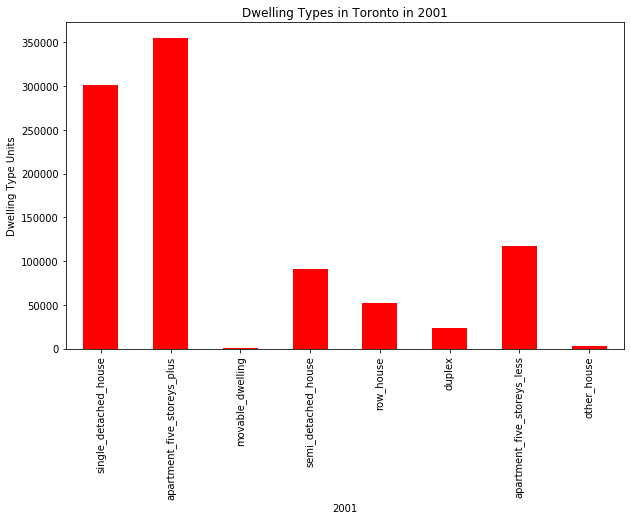

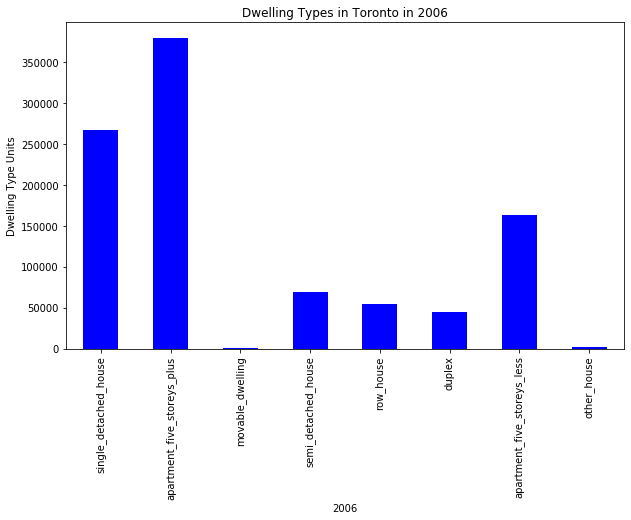

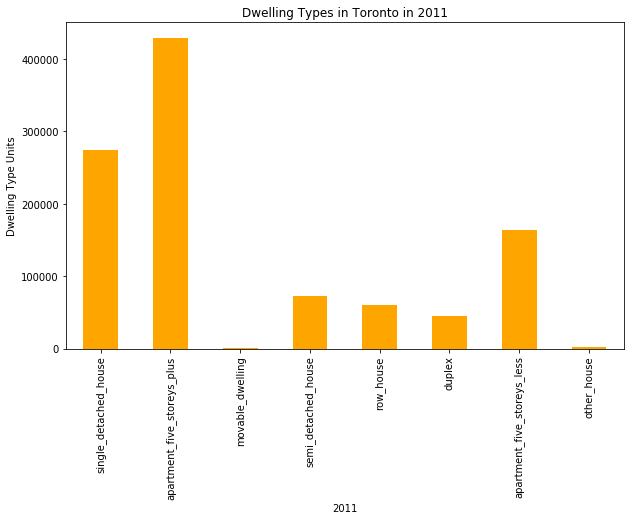

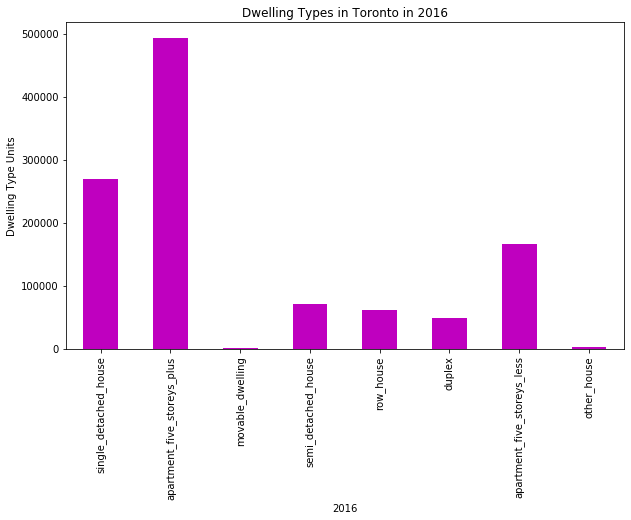

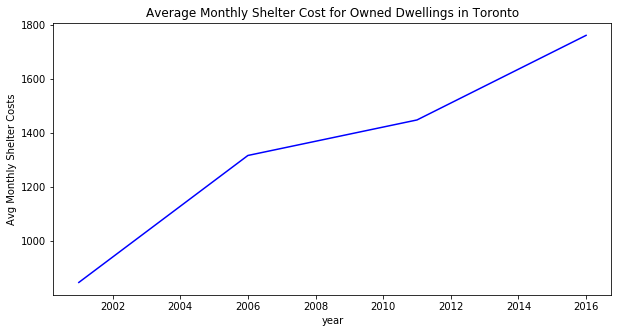

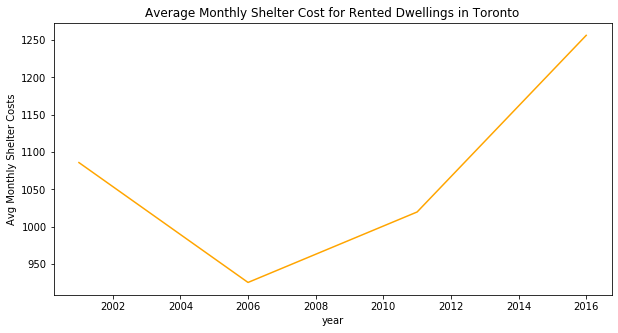

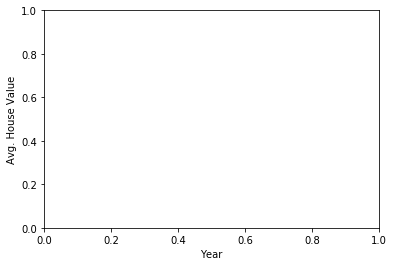

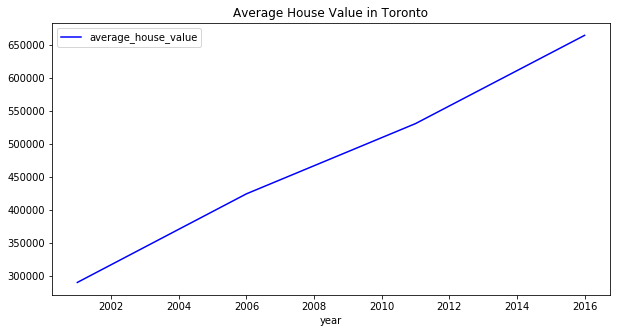

In [7]:
# Create a Title for the Dashboard
Dashboard_Title = pn.pane.Markdown("# Real Estate Investment Analysis of Toronoto from 2001 to 2016")

# Define a welcome text'
welcome_text = pn.pane.Markdown(""" This dashboard presents a visual analysis of historical house values, dwelling types per neighbourhood and dwelling costs in Toronto Metropolitan Area, Ontario according to census data from 2001 to 2016. You can navigate through the 4 tabs namley - Yearly Market Analysis, Shelter Costs Vs. House Value, Neighbourhood Analysis and Top Expensive Neighbourhoods to explore more details about the evolution of the real estate market over the years. This dashboard's goal is to provide charts, maps, and interactive visualizations that help customers explore the data and determine if they want to invest in rental properties in Toronto.""")

welcome = pn.Column(Dashboard_Title, welcome_text, neighbourhood_map())

# Create the Yearly Market Analysis Tab
plot_2001 = create_bar_chart(2001, "Dwelling Types in Toronto in 2001", 2001, "Dwelling Type Units", "red")
plot_2006 = create_bar_chart(2006, "Dwelling Types in Toronto in 2006", 2006, "Dwelling Type Units", "b")
plot_2011 = create_bar_chart(2011, "Dwelling Types in Toronto in 2011", 2011, "Dwelling Type Units", "orange")
plot_2016 = create_bar_chart(2016, "Dwelling Types in Toronto in 2016", 2016, "Dwelling Type Units", "m")
 
yearly_market_analysis_row1 = pn.Row(plot_2001, plot_2006)
yearly_market_analysis_row2 = pn.Row(plot_2011, plot_2016)
yearly_market_analysis_tab = pn.Column(yearly_market_analysis_row1, yearly_market_analysis_row2)

# Create the Shelter Costs Vs. House Value Tab
own = create_line_chart("shelter_costs_owned", "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "b")    
rented = create_line_chart("shelter_costs_rented", "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")    
Shelter_Vs_House_Value_tab = pn.Column(own, rented, average_house_value())

# Create the Neighbourhood Analysis tab
neighbourhood_row1 = pn.Row(average_value_by_neighbourhood(), average_house_value_snapshot())
Neighbourhood_Anal_tab = pn.Column(neighbourhood_row1, number_dwelling_types())

# Top Expensive Neighbourhoods tab
top_expensive_neighbourhoods_tab = pn.Row(top_most_expensive_neighbourhoods(), sunburts_cost_analysis())

# Create a tab layout for the dashboard
dashboard = pn.Tabs(
    ("Welcome", welcome),
    ("Yearly Market Analysis", yearly_market_analysis_tab),
    ("Shelter Costs Vs. House Value", Shelter_Vs_House_Value_tab),
    ("Neighbourhood Analysis", Neighbourhood_Anal_tab),
    ("Top Expensive Neighbourhoods", top_expensive_neighbourhoods_tab)
)

## Serve the Panel Dashboard

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Plotly(Figure)
    [1] Column
        [0] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
        [1] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
    [2] Column
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
    [3] Column
        [0] Row
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                    [1] VSpacer()
            [1] Plotly(Figure)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                [1] VSpacer()
    [4] Row
        [0] HoloViews(Bars)
        [1] Plotly(Figure)
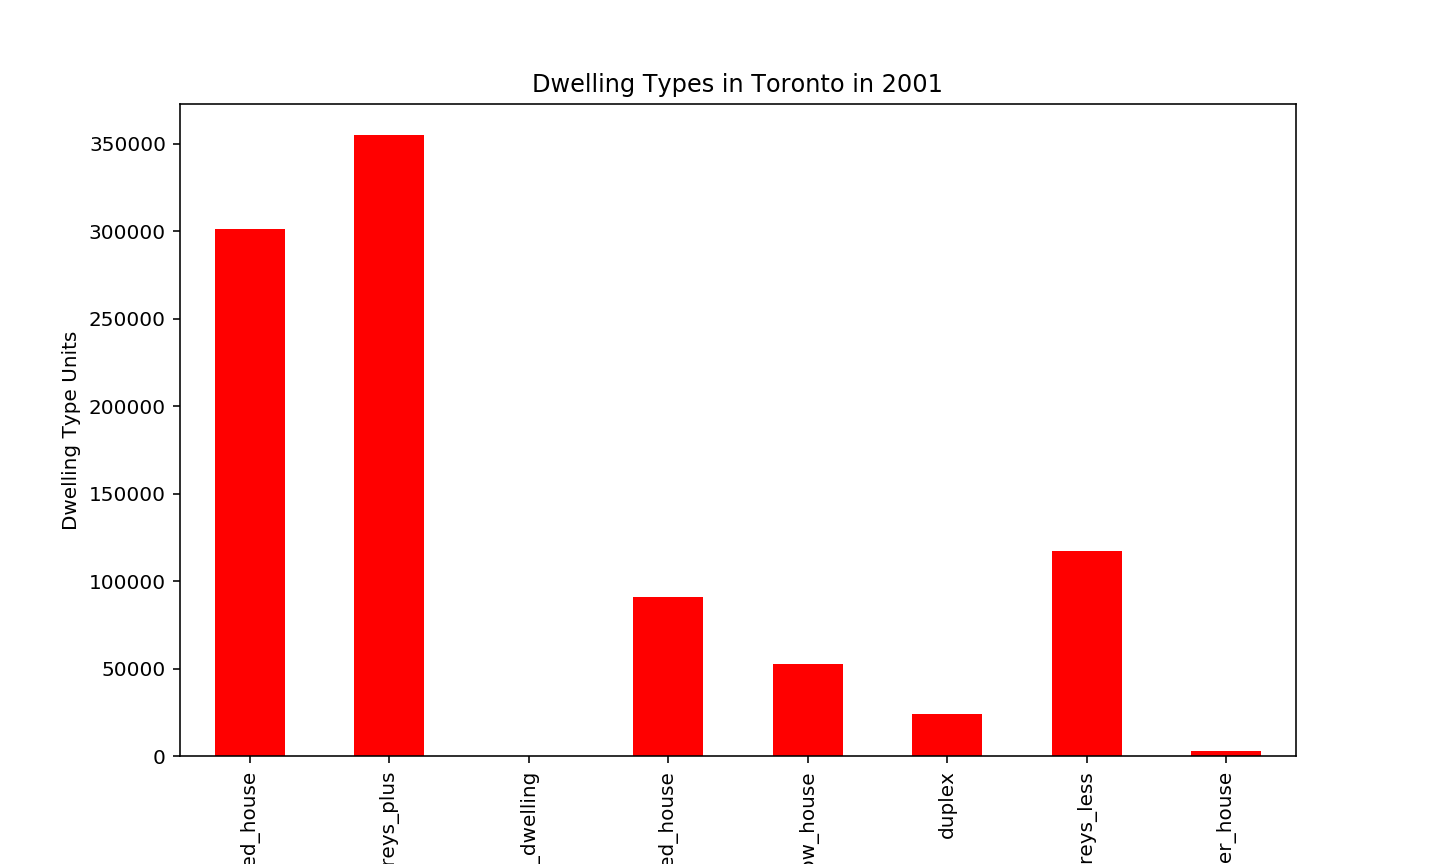
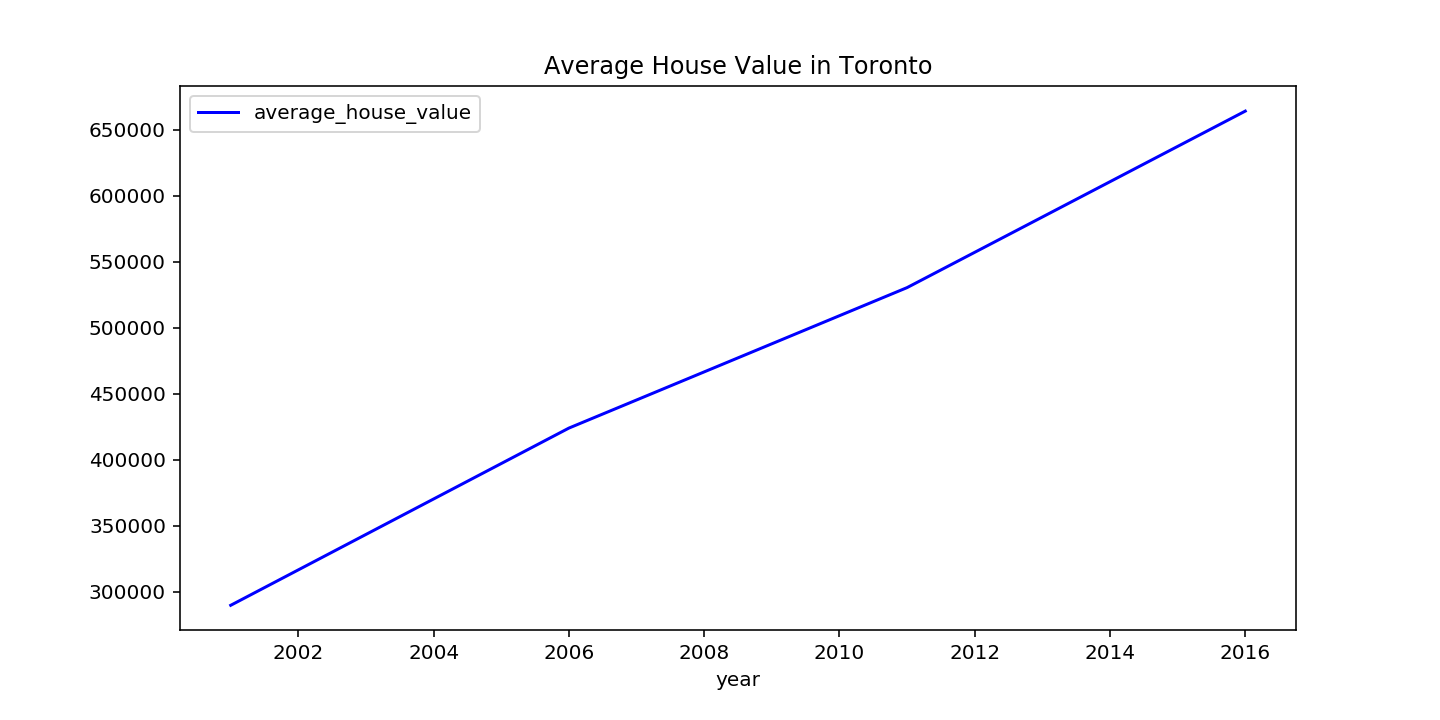
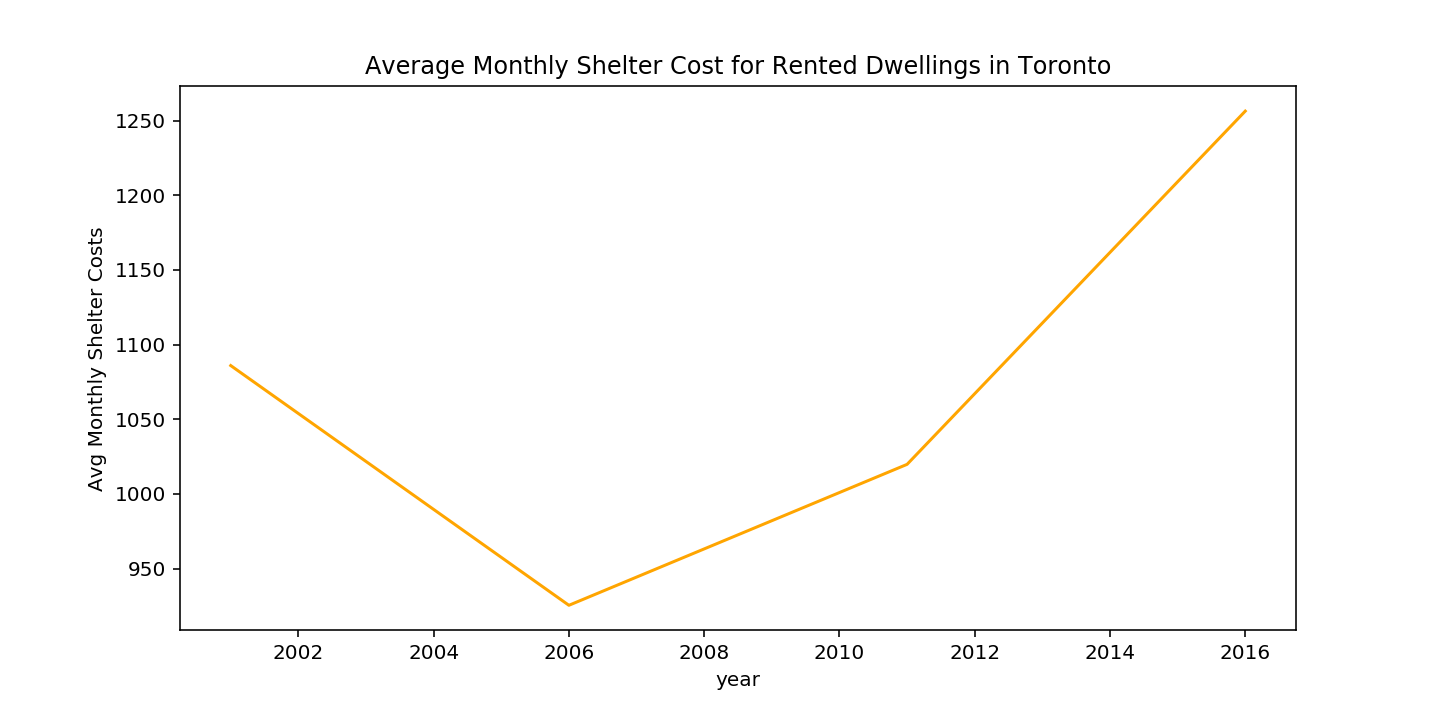
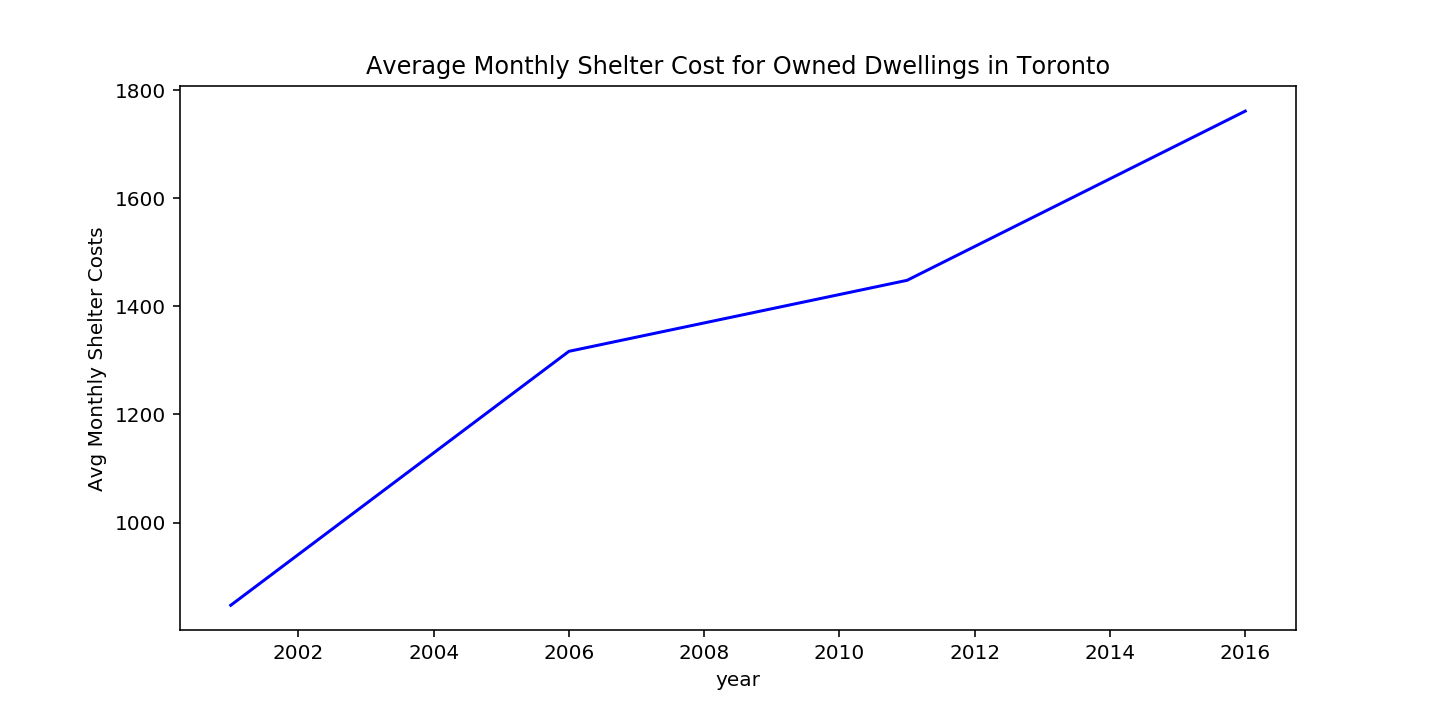
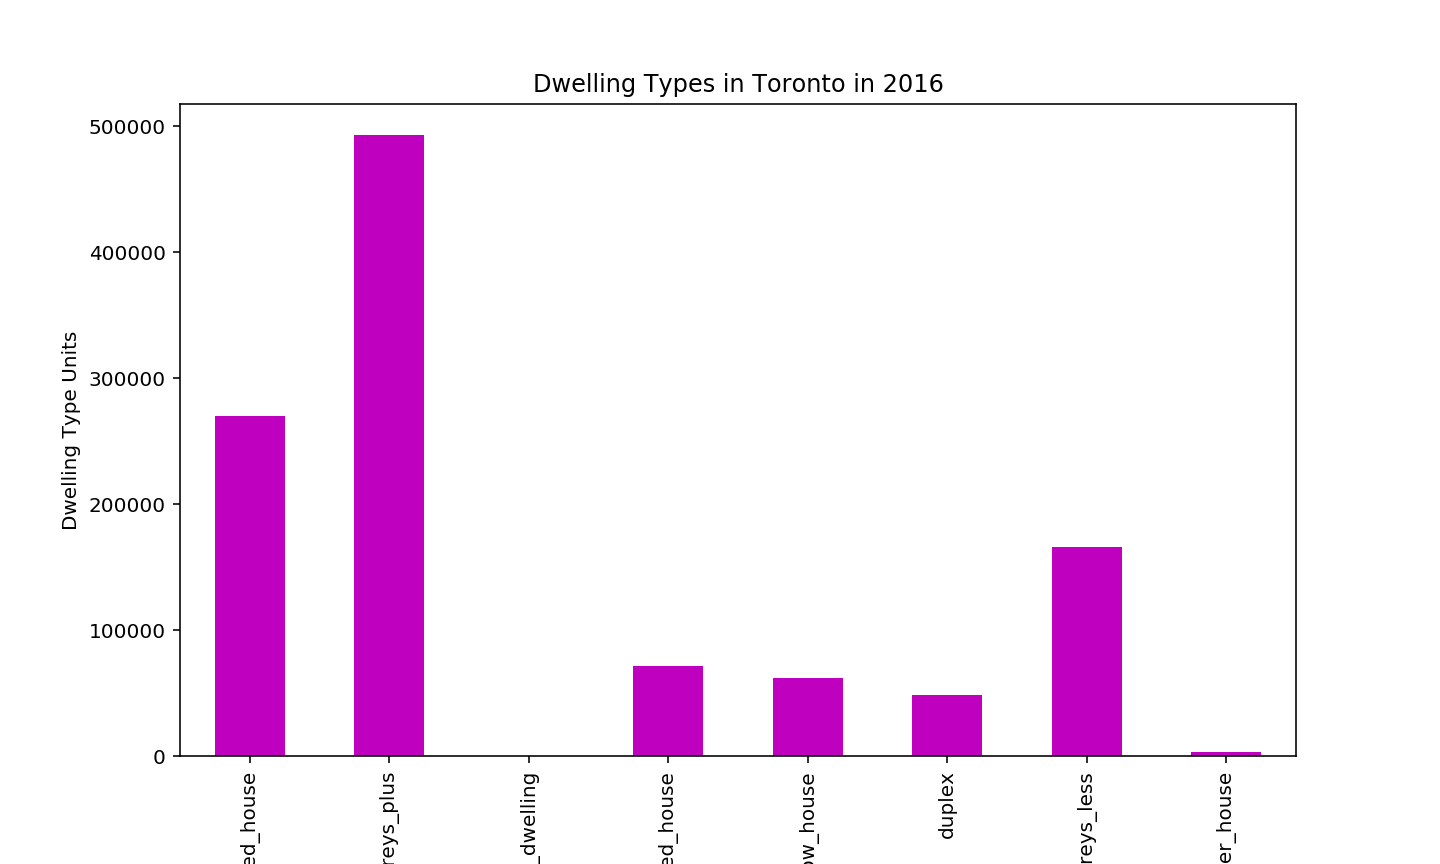
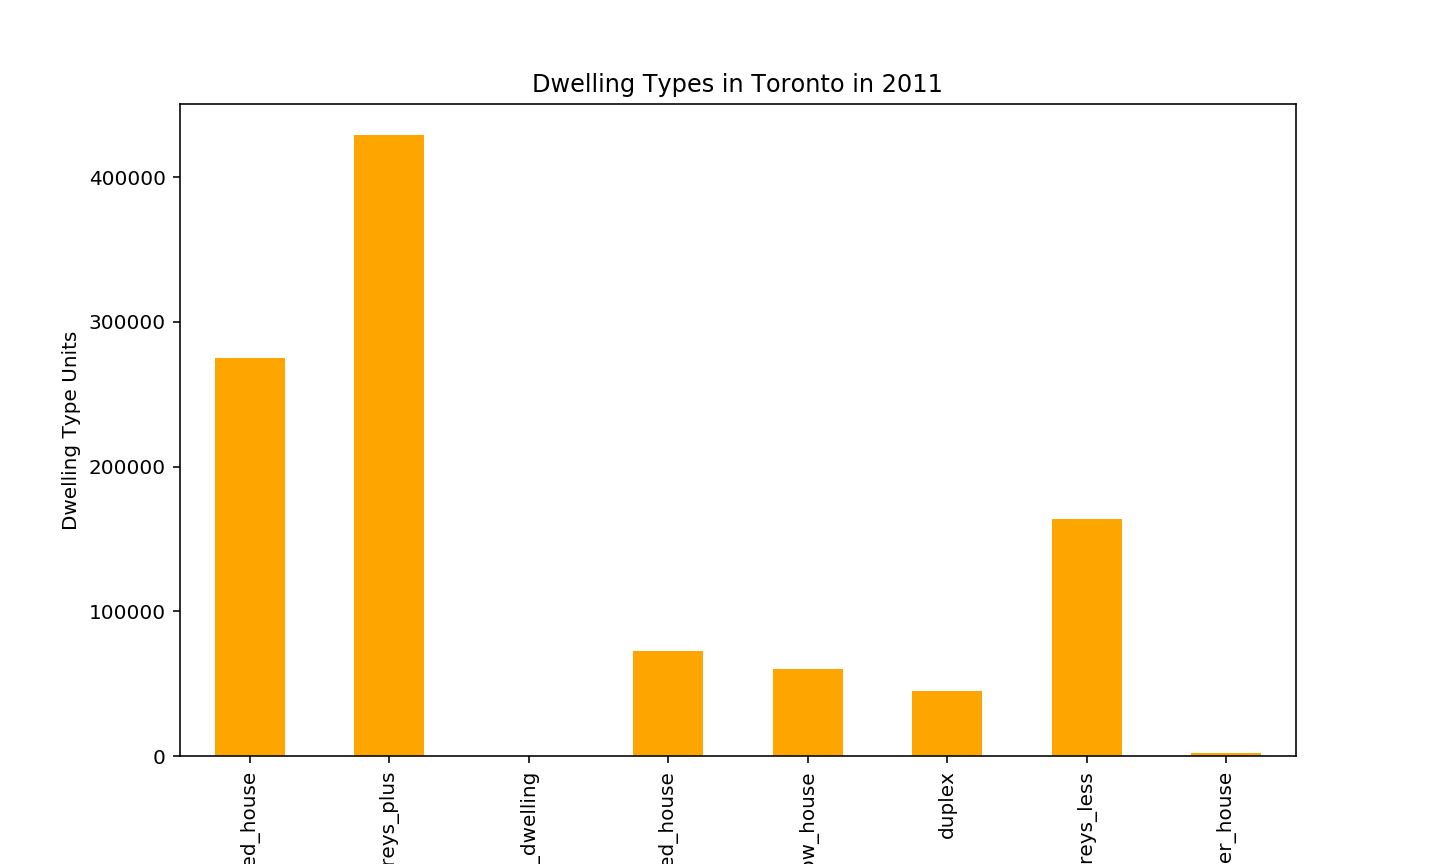
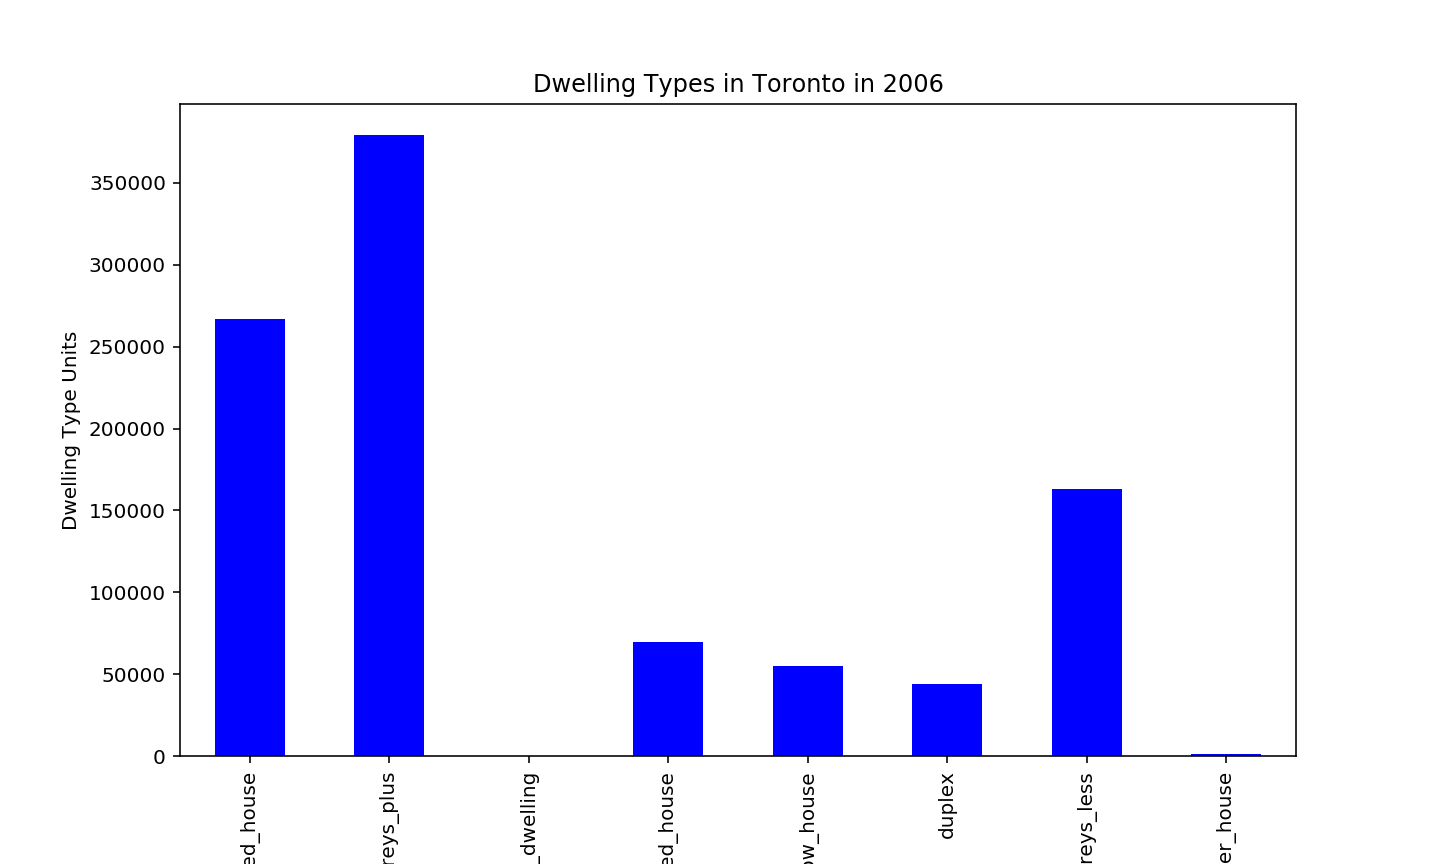

In [8]:
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [9]:
neighbourhood_map()

Plotly(Figure)

In [10]:
# create_bar_chart(data, title, xlabel, ylabel, color)

# # Bar chart for 2001
# create_bar_chart(df_dwelling_units.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# # Bar chart for 2006
# create_bar_chart(df_dwelling_units.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# # Bar chart for 2011
# create_bar_chart(df_dwelling_units.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# # Bar chart for 2016
# create_bar_chart(df_dwelling_units.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

In [11]:
# create_line_chart(data, title, xlabel, ylabel, color)

# # Line chart for owned dwellings
# create_line_chart(df_avg_costs["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
# create_line_chart(df_avg_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

In [12]:
#average_house_value()

In [10]:
average_value_by_neighbourhood()

:DynamicMap   [neighbourhood]
   :Curve   [year]   (average_house_value)

In [13]:
number_dwelling_types()

:DynamicMap   [neighbourhood]
   :Bars   [year,Variable]   (value)

In [14]:
average_house_value_snapshot()

Plotly(Figure)

In [13]:
top_most_expensive_neighbourhoods()

:Bars   [neighbourhood]   (average_house_value)

In [14]:
sunburts_cost_analysis()

Plotly(Figure)